========================PCB DEFECT DATASET DEEP ANALYSIS========================

TRAIN SPLIT: 6361 images
   Images with >1 defect: 6351

VAL SPLIT: 1123 images
   Images with >1 defect: 1122

TEST SPLIT: 832 images
   Images with >1 defect: 831


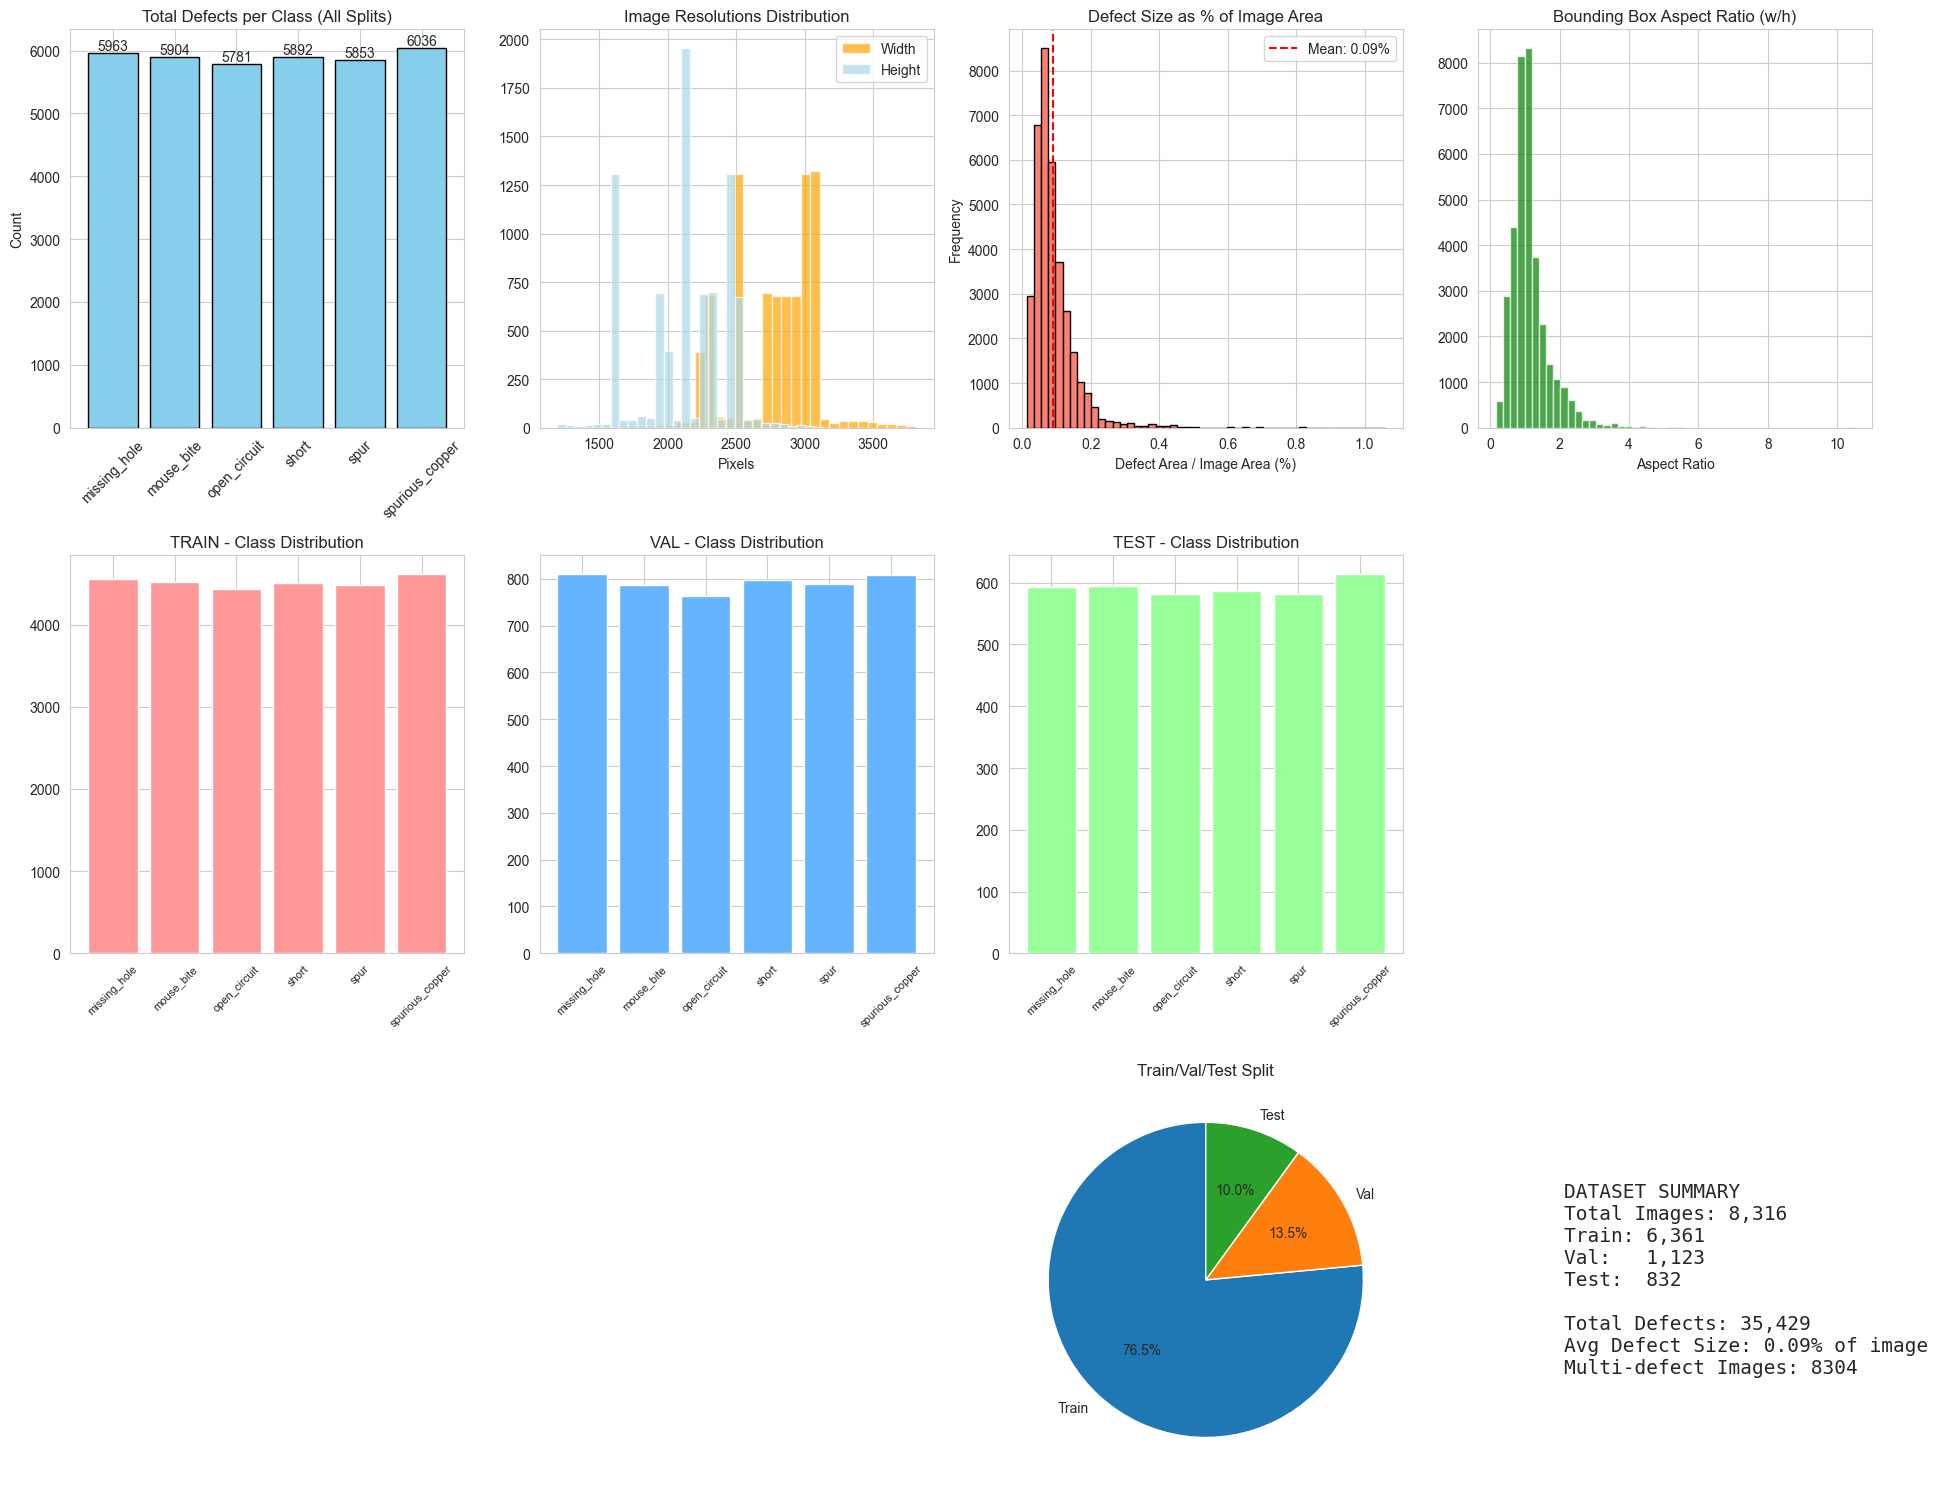


ANALYSIS COMPLETE! Report saved as PCB_DATASET_ANALYSIS_REPORT.png
Include this image in your thesis — examiners LOVE it!


In [2]:
# dataset_analyzer_pro.py
# Run this AFTER prepare_yolo_dataset.py and BEFORE training
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import json
from pathlib import Path

# UPDATE THIS PATH
YOLO_DATASET_PATH = r"E:\IBA_MS_DS 2026\Computer Vision\Project\PCB_DATASET\yolo_dataset"

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def analyze_dataset():
    print("PCB DEFECT DATASET DEEP ANALYSIS".center(80, "="))
    
    splits = ['train', 'val', 'test']
    class_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']
    
    stats = {
        'total_images': 0,
        'images_per_split': {},
        'labels_per_split': {},
        'class_distribution': defaultdict(lambda: defaultdict(int)),
        'bbox_sizes': [],
        'image_resolutions': [],
        'aspect_ratios': [],
        'defect_sizes_pct': [],  # defect area / image area
        'images_with_multiple_defects': 0
    }

    for split in splits:
        img_dir = os.path.join(YOLO_DATASET_PATH, split, 'images')
        lbl_dir = os.path.join(YOLO_DATASET_PATH, split, 'labels')
        
        images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        stats['images_per_split'][split] = len(images)
        stats['total_images'] += len(images)
        
        print(f"\n{split.upper()} SPLIT: {len(images)} images")
        
        multi_defect = 0
        for img_file in images:
            img_path = os.path.join(img_dir, img_file)
            lbl_path = os.path.join(lbl_dir, Path(img_file).stem + '.txt')
            
            img = cv2.imread(img_path)
            if img is None:
                print(f"Corrupted image: {img_path}")
                continue
            h, w = img.shape[:2]
            stats['image_resolutions'].append((w, h))
            stats['aspect_ratios'].append(w / h)
            
            if not os.path.exists(lbl_path):
                continue
                
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
                
            if len(lines) > 1:
                multi_defect += 1
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                # Convert to pixels
                bbox_w = width * w
                bbox_h = height * h
                bbox_area = bbox_w * bbox_h
                img_area = w * h
                defect_pct = (bbox_area / img_area) * 100
                
                stats['class_distribution'][split][class_id] += 1
                stats['bbox_sizes'].append((bbox_w, bbox_h))
                stats['defect_sizes_pct'].append(defect_pct)
        
        stats['images_with_multiple_defects'] += multi_defect
        print(f"   Images with >1 defect: {multi_defect}")

    # PLOTS
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Class Distribution per Split
    plt.subplot(3, 4, 1)
    all_counts = [sum(stats['class_distribution'][s].get(i, 0) for s in splits) for i in range(6)]
    plt.bar(range(6), all_counts, color='skyblue', edgecolor='black')
    plt.xticks(range(6), class_names, rotation=45)
    plt.title('Total Defects per Class (All Splits)')
    plt.ylabel('Count')
    for i, v in enumerate(all_counts):
        plt.text(i, v + 50, str(v), ha='center')

    # 2. Resolution Distribution
    plt.subplot(3, 4, 2)
    widths, heights = zip(*stats['image_resolutions'])
    plt.hist(widths, bins=30, alpha=0.7, label='Width', color='orange')
    plt.hist(heights, bins=30, alpha=0.7, label='Height', color='lightblue')
    plt.legend()
    plt.title('Image Resolutions Distribution')
    plt.xlabel('Pixels')

    # 3. Defect Size (% of image)
    plt.subplot(3, 4, 3)
    plt.hist(stats['defect_sizes_pct'], bins=50, color='salmon', edgecolor='black')
    plt.title('Defect Size as % of Image Area')
    plt.xlabel('Defect Area / Image Area (%)')
    plt.ylabel('Frequency')
    mean_size = np.mean(stats['defect_sizes_pct'])
    plt.axvline(mean_size, color='red', linestyle='--', label=f'Mean: {mean_size:.2f}%')
    plt.legend()

    # 4. Bounding Box Aspect Ratio
    plt.subplot(3, 4, 4)
    bbox_w, bbox_h = zip(*stats['bbox_sizes'])
    ratios = np.array(bbox_w) / np.array(bbox_h)
    plt.hist(ratios, bins=50, color='green', alpha=0.7)
    plt.title('Bounding Box Aspect Ratio (w/h)')
    plt.xlabel('Aspect Ratio')

    # 5–10: Per-class distribution in train/val/test
    for i, split in enumerate(splits):
        plt.subplot(3, 4, 5 + i)
        counts = [stats['class_distribution'][split].get(j, 0) for j in range(6)]
        plt.bar(range(6), counts, color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff99cc','#c2c2f0'][i])
        plt.title(f'{split.upper()} - Class Distribution')
        plt.xticks(range(6), class_names, rotation=45, fontsize=8)

    # 11. Split Pie Chart
    plt.subplot(3, 4, 11)
    sizes = [stats['images_per_split']['train'], stats['images_per_split']['val'], stats['images_per_split']['test']]
    plt.pie(sizes, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%', startangle=90)
    plt.title('Train/Val/Test Split')

    # 12. Summary Table
    plt.subplot(3, 4, 12)
    plt.axis('off')
    summary = f"""
    DATASET SUMMARY
    Total Images: {stats['total_images']:,}
    Train: {stats['images_per_split']['train']:,}
    Val:   {stats['images_per_split']['val']:,}
    Test:  {stats['images_per_split']['test']:,}
    
    Total Defects: {sum(all_counts):,}
    Avg Defect Size: {mean_size:.2f}% of image
    Multi-defect Images: {stats['images_with_multiple_defects']}
    """
    plt.text(0.1, 0.5, summary, fontsize=14, verticalalignment='center', fontfamily='monospace')

    plt.tight_layout()
    plt.savefig('PCB_DATASET_ANALYSIS_REPORT.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nANALYSIS COMPLETE! Report saved as PCB_DATASET_ANALYSIS_REPORT.png")
    print("Include this image in your thesis — examiners LOVE it!")

if __name__ == "__main__":
    analyze_dataset()